In [4]:
# !pip install seaborn


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools
import json

# Import data
- all thresholds: df_both_sessions

In [6]:
df_both_sessions_raw = pd.read_csv('tidy_both_sessions_thresholds_per_trial_log.csv')

# Data cleaning

In [7]:
df_both_sessions = df_both_sessions_raw.copy()

## Filter participants based on the quality of individual thresholds
Exclude participants with:
- acuity and crowding: numTrialsSent < 35
- rsvp: numTrialsSent < 24
- ordinary reading: accuracy < 60
- questSD > 1 doesn't apply with the changing number of trials
- large test-retest ratio

In [8]:
# # num_trials_required = 23  # 23 trials for short staircase
# num_trials_required = 35  # 35 trials for original staircase

# acuity_low_trial_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(acuity_low_trial_ids)}')

# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "acuity")
#         & (df_both_sessions["prolificID"].isin(acuity_low_trial_ids))
#     )
# ].copy()

# # num_trials_required = 23  # 23 trials for short staircase
# num_trials_required = 35  # 35 trials for original staircase

# crowding_low_trial_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(crowding_low_trial_ids)}')

# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "crowding")
#         & (df_both_sessions["prolificID"].isin(crowding_low_trial_ids))
#     )
# ].copy()

# # num_trials_required = 16  # 16 trials for short staircase
# num_trials_required = 24  # 24 trials for original staircase

# rsvp_low_trial_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "rsvp")
#         & (df_both_sessions["prolificID"].isin(rsvp_low_trial_ids))
#     )
# ].copy()

# reading_low_accuracy_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["reading"]) & (df_both_sessions["readingCQAccuracy"] < 60),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 measurement with accuracy < 60%: {len(reading_low_accuracy_ids)}')


# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "reading")
#         & (df_both_sessions["prolificID"].isin(reading_low_accuracy_ids))
#     )
# ].copy()

# def compute_test_retest_ratio(df, block1_colname, block2_colname):
# 	'''
# 	Compute test-retest ratio: log10(block2 / block1)
#     Since the data are already log-transformed, the results would be equivalent to:
#     block2 - block1
# 	'''
# 	return df[block2_colname] - df[block1_colname]

# def flag_outliers_IQR(
#     df,
#     col_prefix="log_ratio",
#     criterion_k=1.5,
#     verbose=True,
# ):
#     """
#     Add boolean outlier flags to ratio columns in a pivot table.

#     - Detects columns via `col_prefix`.
#     - For each ratio col: computes Q1, Q3, IQR; flags values < Q1 - k*IQR or > Q3 + k*IQR.
#     - Writes a boolean flag column '<ratio_col>_is_outlier'.
#     Returns a new DataFrame (does not modify input).
#     """
#     df = df.copy()

#     # Identify ratio columns
#     colNames = [c for c in df.columns if c.startswith(col_prefix)]

#     for col in colNames:
#         # Compute IQR bounds (NaNs ignored by quantile)
#         q1 = df[col].quantile(0.25)
#         q3 = df[col].quantile(0.75)
#         iqr = q3 - q1
#         lower = q1 - criterion_k * iqr
#         upper = q3 + criterion_k * iqr

#         mask = (df[col] < lower) | (df[col] > upper)
#         out_col = f"{col}_is_outlier"
#         df[out_col] = mask.fillna(False)

#         if verbose:
#             n = int(mask.sum())
#             print(f"{col}: Q1={q1:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}, "
#                   f"bounds=({lower:.4f}, {upper:.4f}), outliers={n}")

#     return df


# def exclusion_ids_from_flags(
#     df_wide: pd.DataFrame,
#     task: str,
#     flag_cols=None,                 # e.g., ["log_ratio_2vs1_is_outlier"] or None → auto-pick all *_is_outlier
#     require="any",                  # "any" = exclude if ANY flag True; "all" = exclude only if ALL flags True
# ):
#     """
#     Return a list of prolificID to exclude for a given task, based on boolean outlier flags.
#     df_wide must include columns: 'prolificID', 'taskName', and *_is_outlier booleans.
#     """
#     d = df_wide[df_wide["taskName"] == task]

#     if flag_cols is None:
#         flag_cols = [c for c in d.columns if c.endswith("_is_outlier")]

#     if not flag_cols:
#         return []  # nothing to check

#     if require == "any":
#         bad = d.groupby("prolificID")[flag_cols].any().any(axis=1)
#     elif require == "all":
#         bad = d.groupby("prolificID")[flag_cols].all().all(axis=1)
#     else:
#         raise ValueError("Invalid require value. Use 'any' or 'all'.")
#     return bad[bad].index.tolist()

# def filter_excluding_ids(df_wide: pd.DataFrame, *exclude_lists):
#     """
#     Return df_wide with rows whose prolificID is NOT in any of the exclude lists.
#     Accepts multiple lists/sets of IDs.
#     """
#     # Merge all input lists/sets into one set
#     exclude_ids = set().union(*exclude_lists)
#     return df_wide[~df_wide["prolificID"].isin(exclude_ids)].copy()

# def filter_including_ids(df_wide: pd.DataFrame, *include_lists):
#     """
#     Return df_wide with rows whose prolificID IS IN any of the exclude lists.
#     Accepts multiple lists/sets of IDs.
#     """
#     # Merge all input lists/sets into one set
#     include_ids = set().union(*include_lists)
#     return df_wide[df_wide["prolificID"].isin(include_ids)].copy()

# # df_acuity = df_wide[df_wide['taskName'] == 'acuity'].copy()
# # df_acuity['log_ratio'] = compute_test_retest_ratio(df_acuity, 'repeat1', 'repeat2')
# # df_acuity = flag_outliers_IQR(df_acuity)
# # acuity_bad_ratio_ids = exclusion_ids_from_flags(df_acuity, task='acuity')
# # print(len(acuity_bad_ratio_ids))

# df_rsvp = df_wide[df_wide['taskName'] == 'rsvp'].copy()
# df_rsvp['log_ratio'] = compute_test_retest_ratio(df_rsvp, 'repeat1', 'repeat2')
# df_rsvp = flag_outliers_IQR(df_rsvp)
# rsvp_bad_ratio_ids = exclusion_ids_from_flags(df_rsvp, task='rsvp')
# print(f'Number of participants getting excluded by test-retest ratio: task: rsvp, n = {len(rsvp_bad_ratio_ids)}')


## Filter participants who we want to exclude in the final analysis

In [9]:
# import participant lists from file
with open("exclude_dict.json", "r") as f:
    exclude_dict = json.load(f)


for task, exclude_ids in exclude_dict.items():
    df_both_sessions = df_both_sessions[
        ~(
            (df_both_sessions["taskName"] == task)
            & (df_both_sessions["prolificID"].isin(exclude_ids))
        )
    ]


## Filter data that we want to include in the analysis and pivot

In [10]:
df_for_analysis = df_both_sessions.copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "crowding")
        & (df_for_analysis["repeat"].isin([3, 4]))
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "acuity")
        & (df_for_analysis["meridian"] == "L8")
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "crowding")
        & (df_for_analysis["meridian"] == "L8")
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "reading")
        & (df_for_analysis["meridian"] == "second")
    )
].copy()

df_for_analysis = df_for_analysis[['prolificID', 'taskName', 'repeat', 'trial_index', 'threshold']]

display(df_for_analysis)

,prolificID,taskName,repeat,trial_index,threshold
145,5f0788c06b220f03231666a0,acuity,1,1,0.602060
146,5f0788c06b220f03231666a0,acuity,1,2,0.602060
147,5f0788c06b220f03231666a0,acuity,1,3,-0.167358
148,5f0788c06b220f03231666a0,acuity,1,4,-0.684495
149,5f0788c06b220f03231666a0,acuity,1,5,-1.030995
...,...,...,...,...,...
82050,5d7bde81c7390f00169b2fdf,reading,2,3,2.506401
82053,5f98099d48060d0450394002,reading,2,2,2.491295
82054,5f98099d48060d0450394002,reading,2,3,2.433745
82057,5fb281433a31c686f0ec3ecb,reading,2,2,2.669561


In [11]:
df_wide = (
    df_for_analysis
    .pivot_table(index=["prolificID", "taskName", "trial_index"],
                 columns="repeat",
                 values="threshold")
    .reset_index()
)
df_wide.columns.name = None
df_wide = df_wide.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

display(df_wide)

,prolificID,taskName,trial_index,repeat1,repeat2
0,559ad287fdf99b219a612d22,acuity,1,0.602060,0.602060
1,559ad287fdf99b219a612d22,acuity,2,0.602060,0.602060
2,559ad287fdf99b219a612d22,acuity,3,-0.167358,-0.167358
3,559ad287fdf99b219a612d22,acuity,4,-0.684495,-0.684495
4,559ad287fdf99b219a612d22,acuity,5,0.030174,-0.014603
...,...,...,...,...,...
13191,67fffee26ec983c07f3a2abd,acuity,35,-0.417214,-0.544063
13192,67fffee26ec983c07f3a2abd,acuity,36,-0.423829,-0.530340
13193,67fffee26ec983c07f3a2abd,reading,2,2.030383,2.540411
13194,67fffee26ec983c07f3a2abd,reading,3,2.108095,2.396606


In [12]:
# df_avg_meridian = (
#     df_both_sessions
#     .pivot_table(index=['prolificID','taskName','repeat','trial_index'],
#                  values='threshold', aggfunc='mean')
#     .reset_index()
#     .rename(columns={'threshold': 'threshold_mean'})
# )
# df_avg_meridian = (
#     df_both_sessions
#     .pivot_table(index=["prolificID", "taskName", "trial_index"],
#                  columns="repeat",
#                  values="threshold")
#     .reset_index()
# )
# df_avg_meridian.columns.name = None
# df_avg_meridian = df_avg_meridian.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

# display(df_avg_meridian)

# Analysis
- note that everything in is now logged

For now let's just use the right meridian for acuity and crowding, repeats 1 and 2 for crowding, and first passage for reading

## Functions:

In [13]:
def summarize_task(X):
    """
    take only the repeat columns as its input (X)
    """

    # per-participant mean across repeats
    subj_mean = X.mean(axis=1, skipna=True)

    # stats
    within_var = X.var(axis=1, ddof=1).mean(skipna=True)
    between_var = np.nanvar(subj_mean.to_numpy(), ddof=1)
    grand_mean = subj_mean.mean(skipna=True)

    # split-half reliability → Spearman–Brown
    if X.shape[1] < 2:
        r_ceiling = np.nan
    else:
        n = X.shape[1]
        first, last = X.iloc[:, :n//2].mean(axis=1), X.iloc[:, n//2:].mean(axis=1)
        odd, even  = X.iloc[:, 1::2].mean(axis=1), X.iloc[:, 0::2].mean(axis=1)

        def r(a,b):
            a, b = a.to_numpy(), b.to_numpy()
            m = np.isfinite(a) & np.isfinite(b)
            return np.nan if m.sum() < 3 else stats.pearsonr(a[m], b[m])[0]

        r_FL, r_OE = r(first,last), r(odd,even)
        r_i = np.sqrt(r_FL * r_OE) if np.isfinite(r_FL) and np.isfinite(r_OE) else np.nan
        if np.isnan(r_i):
            r_ceiling = np.nan
        else:
            r_i = float(np.clip(r_i, 0.0, 0.999999))
            r_ceiling = (2 * r_i) / (1 + r_i)

    return pd.Series({
        "within_subj_variance": within_var,
        "btw_subj_variance": between_var,
        "mean": grand_mean,
        "r(test,retest)": r_i,
        "expected_reliability": r_ceiling
    })

def compute_reliability_task(df_wide, task_name, trial_numbers, repeats_include=['repeat1','repeat2']):

    df_wide = df_wide.copy()

    df_task = df_wide[df_wide['taskName'] == task_name]
    results = []

    for t in sorted(trial_numbers):

        df_trial = df_task[df_task['trial_index'] == t]

        X = df_trial.drop(columns=["prolificID", "taskName", "trial_index"])
        X = X[repeats_include].copy()
        results_trial = summarize_task(X)
        results_trial["taskName"] = task_name
        results_trial["trial_index"] = t

        results.append(results_trial)
    
    results_df = pd.DataFrame(results).reset_index(drop=True)
    results_df = results_df[['taskName', 'trial_index', 'mean', 'r(test,retest)', 'expected_reliability']]
        
    return results_df

        

In [14]:
def print_measured_corrected_r(df, var_x, var_y, r_ceiling_x, r_ceiling_y):

    df = df.copy()
    
    # Filter for non-NaN pairs
    valid_mask = df[[var_x, var_y]].notna().all(axis=1)
    x_vals = df.loc[valid_mask, var_x]
    y_vals = df.loc[valid_mask, var_y]

    # Compute measured correlation
    r_measured, p_value = stats.pearsonr(x_vals, y_vals)

    # Compute combined noise ceiling
    r_ceiling_combined = np.sqrt(r_ceiling_x * r_ceiling_y)

    # Apply correction
    r_corrected = r_measured / r_ceiling_combined

    # Return results in dataframe form
    return pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'est_reliability_x': [r_ceiling_x],
        'est_reliability_y': [r_ceiling_y],
        'noise_ceiling_xy': [r_ceiling_combined],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })



In [38]:
def select_trials(all_trials, percentages):

    ind_trials = np.ceil(percentages * len(all_trials)).astype(int)-1
    selected_trials = [all_trials[i] for i in ind_trials]

    return selected_trials


def compute_corr_percent_trials(df_wide, task_name1, task_name2, 
                                trial_numbers1=list(range(2, 36)), trial_numbers2=list(range(2, 36)), 
                                repeats_include1=['repeat1','repeat2'], repeats_include2=['repeat1','repeat2']):

    df_wide = df_wide.copy()

    df_task1 = df_wide[df_wide['taskName'] == task_name1]
    df_task2 = df_wide[df_wide['taskName'] == task_name2]

    percentage = np.linspace(5, 100, 15)/100
    n_trials_task1 = select_trials(trial_numbers1, percentage)
    n_trials_task2 = select_trials(trial_numbers2, percentage)

    results = []

    for ind in range(len(percentage)):

        this_percentage = percentage[ind]
        df_trial_task1 = df_task1[df_task1['trial_index'] == n_trials_task1[ind]].copy().drop(columns=["taskName", "trial_index"])
        df_trial_task1 = df_trial_task1[['prolificID'] + repeats_include1].copy()
        df_trial_task2 = df_task2[df_task2['trial_index'] == n_trials_task2[ind]].copy().drop(columns=["taskName", "trial_index"])
        df_trial_task2 = df_trial_task2[['prolificID'] + repeats_include2].copy()

        merged = pd.merge(
            df_trial_task1.reset_index(drop=True), 
            df_trial_task2.reset_index(drop=True), 
            on='prolificID', 
            suffixes=('_task1', '_task2')
        )

        trials_task1 = merged[[col for col in merged.columns if col.endswith('_task1')]]
        summary_task1 = summarize_task(trials_task1)
        x_vals = np.mean(trials_task1, axis=1)
        assert len(trials_task1) == len(x_vals), "trials_task1 and x_vals must be the same length"


        trials_task2 = merged[[col for col in merged.columns if col.endswith('_task2')]]
        summary_task2 = summarize_task(trials_task2)
        y_vals = np.mean(trials_task2, axis=1)
        assert len(trials_task2) == len(y_vals), "trials_task2 and y_vals must be the same length"


        assert len(x_vals) == len(y_vals), "x and y must be the same length"
        # Filter for non-NaN pairs
        valid_mask = pd.DataFrame({'x': x_vals, 'y': y_vals}).notna().all(axis=1)
        x_vals = x_vals[valid_mask]
        y_vals = y_vals[valid_mask]
        
        r_measured, p_value = stats.pearsonr(x_vals, y_vals)
        r_ceiling_combined = np.sqrt(summary_task1['expected_reliability'] * summary_task2['expected_reliability'])
        r_corrected = r_measured / r_ceiling_combined

        results.append({
            'var_x': task_name1,
            'var_y': task_name2,
            'percentage_of_trials': this_percentage,
            'trial_number_x': n_trials_task1[ind],
            'trial_number_y': n_trials_task2[ind],
            'est_reliability_x': summary_task1['expected_reliability'],
            'est_reliability_y': summary_task2['expected_reliability'],
            'noise_ceiling_xy': r_ceiling_combined,
            'r_measured': r_measured,
            'r_corrected': r_corrected
        })

    results_df = pd.DataFrame(results).reset_index(drop=True)
        
    return results_df

## Compute reliabilities

In [16]:
rel_acuity = compute_reliability_task(df_wide, task_name='acuity', trial_numbers=list(range(2, 36))) # from the second to the 35th trial
rel_crowding = compute_reliability_task(df_wide, task_name='crowding', trial_numbers=list(range(2, 36)))
rel_rsvp = compute_reliability_task(df_wide, task_name='rsvp', trial_numbers=list(range(3, 24))) # from the third to the 24th trial
rel_reading = compute_reliability_task(df_wide, task_name='reading', trial_numbers=[2, 3])

In [17]:
# rel_acuity = compute_reliability_task(df_avg_meridian, task_name='acuity', trial_numbers=list(range(2, 36))) # from the second to the 35th trial
# rel_crowding = compute_reliability_task(df_avg_meridian, task_name='crowding', trial_numbers=list(range(2, 36)), repeats_include=['repeat1','repeat2', 'repeat3','repeat4'])
# rel_rsvp = compute_reliability_task(df_avg_meridian, task_name='rsvp', trial_numbers=list(range(3, 24))) # from the third to the 24th trial
# rel_reading = compute_reliability_task(df_avg_meridian, task_name='reading', trial_numbers=[2, 3])

In [40]:
acuity_crowding = compute_corr_percent_trials(df_wide, 'acuity', 'crowding')
acuity_rsvp = compute_corr_percent_trials(df_wide, 'acuity', 'rsvp', trial_numbers2=list(range(3, 24)))
acuity_reading = compute_corr_percent_trials(df_wide, 'acuity', 'reading', trial_numbers2=list(range(2,4)))
crowding_rsvp = compute_corr_percent_trials(df_wide, 'crowding', 'rsvp', trial_numbers2=list(range(3, 24)))
crowding_reading = compute_corr_percent_trials(df_wide, 'crowding', 'reading', trial_numbers2=list(range(2,4)))


# Visualization

## Reliability as a function of # of trials

In [ ]:
def plot_reliability(df_results, task_name, val_name):
    df_task = df_results[df_results["taskName"] == task_name]
    plt.figure(figsize=(4, 4))
    plt.plot(df_task["trial_index"], df_task[val_name], marker="o")
    plt.xlabel("trial index")
    plt.ylabel(val_name)
    plt.title(f"{task_name}")
    plt.ylim(0, 1)
    plt.show()


In [ ]:
def plot_corr_and_reliability(df):
    # Extract unique var_x and var_y
    var_x = df['var_x'].unique()[0]
    var_y = df['var_y'].unique()[0]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Subplot 1: Reliability vs Percentage of Trials
    axs[0].plot(df['percentage_of_trials'], df['est_reliability_x'], 'o-', label=f'{var_x} reliability')
    axs[0].plot(df['percentage_of_trials'], df['est_reliability_y'], 'o-', label=f'{var_y} reliability')
    axs[0].set_xlabel('Percentage of trials')
    axs[0].set_ylabel('Estimated reliability')
    axs[0].set_title('Reliability vs percentage of trials')
    axs[0].legend()
    # axs[0].set_aspect('equal', adjustable='box')

    # Subplot 2: Correlation vs Percentage of Trials
    axs[1].plot(df['percentage_of_trials'], df['r_measured'], 'o-', label='Measured r')
    axs[1].plot(df['percentage_of_trials'], df['r_corrected'], 'o-', label='Corrected r')
    axs[1].set_xlabel('Percentage of trials')
    axs[1].set_ylabel('Correlation')
    axs[1].set_title('Correlation vs percentage of trials')
    axs[1].legend()
    # axs[1].set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

In [ ]:
# plot_reliability(rel_acuity, "acuity", "r(test,retest)")
# plot_reliability(rel_acuity, "acuity", "expected_reliability")

# plot_reliability(rel_crowding, "crowding", "r(test,retest)")
# plot_reliability(rel_crowding, "crowding", "expected_reliability")

# plot_reliability(rel_rsvp, "rsvp", "r(test,retest)")
# plot_reliability(rel_rsvp, "rsvp", "expected_reliability")

# plot_reliability(rel_reading, "reading", "r(test,retest)")
# plot_reliability(rel_reading, "reading", "expected_reliability")

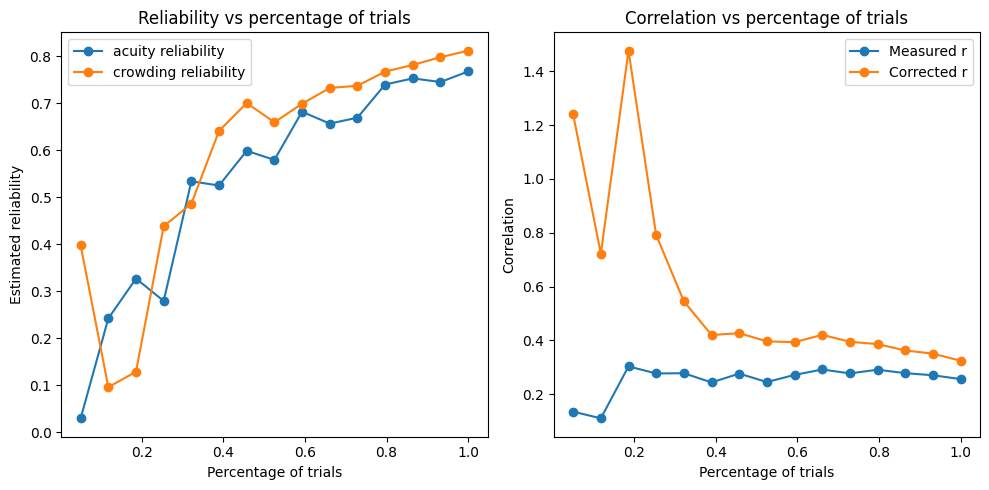

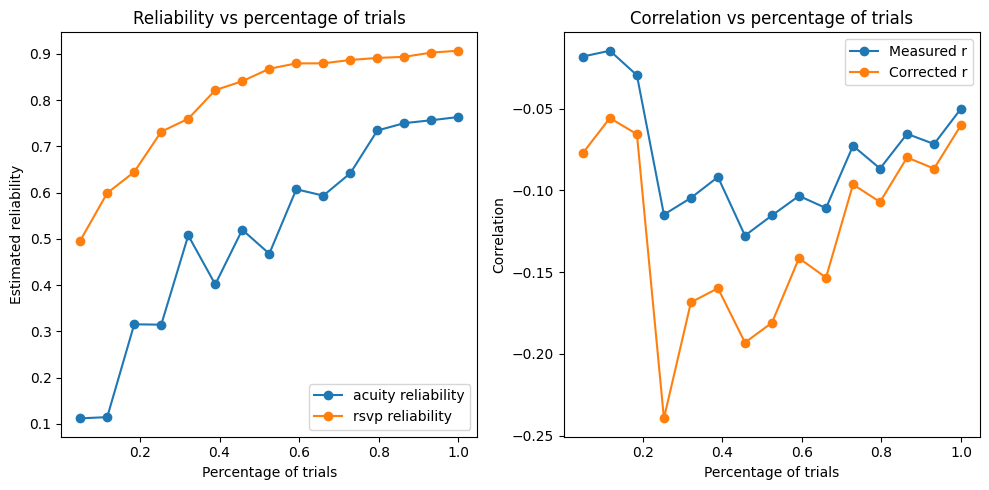

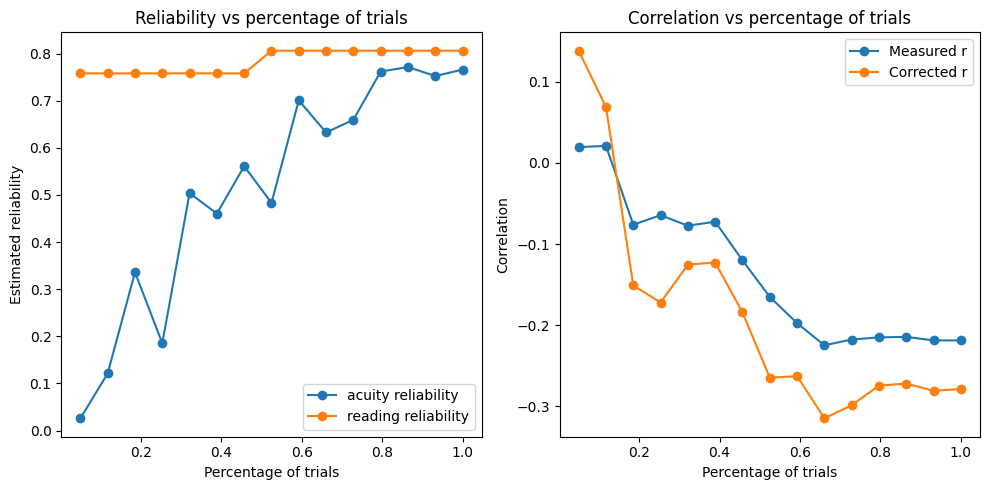

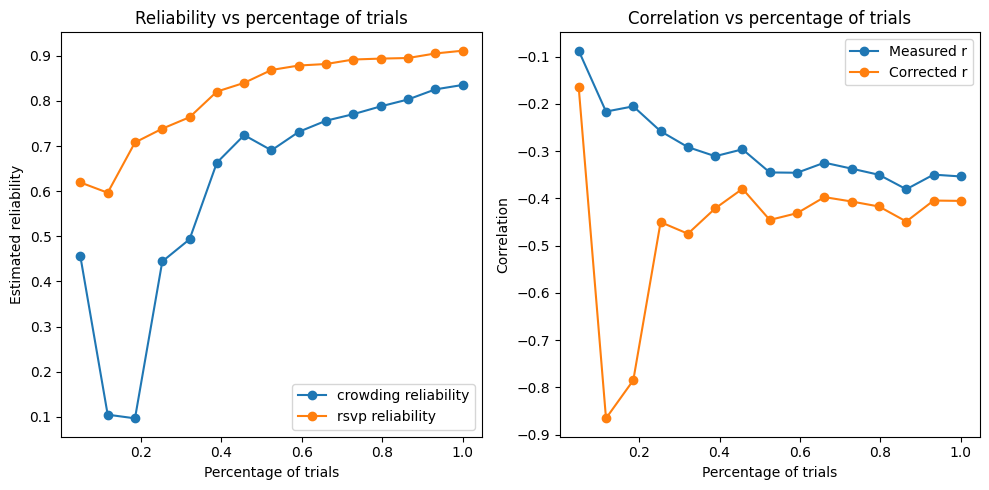

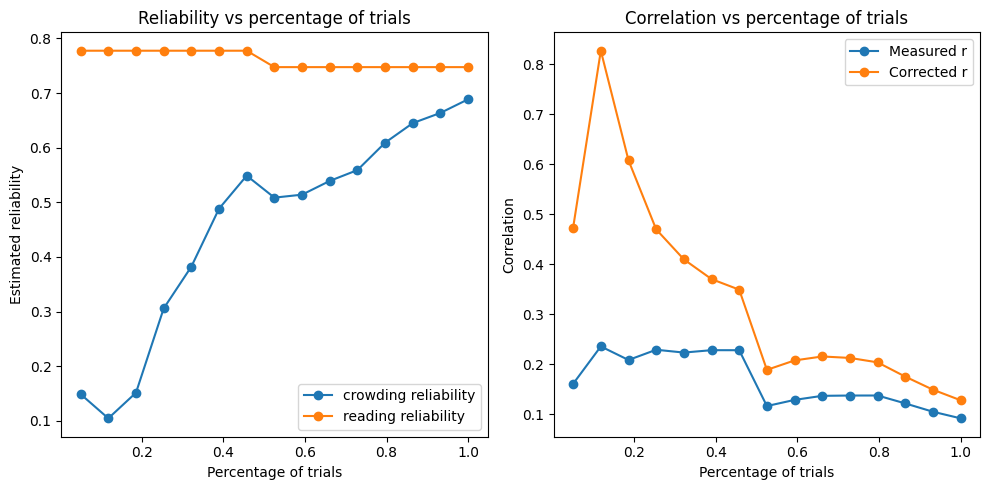

In [68]:
plot_corr_and_reliability(acuity_crowding)
plot_corr_and_reliability(acuity_rsvp)
plot_corr_and_reliability(acuity_reading)

plot_corr_and_reliability(crowding_rsvp)
plot_corr_and_reliability(crowding_reading)


# Sanity check

In [ ]:
tt = pd.read_csv('tidy_both_sessions_thresholds_log.csv')

# Update meridian values for reading tasks
tt.loc[
    (tt['taskName'] == 'reading') & 
    (tt['meridian'].isin(['Beaver', 'Desert'])),
    'meridian'
] = 'first'

tt.loc[
    (tt['taskName'] == 'reading') & 
    (tt['meridian'].isin(['Winter', 'Islands'])),
    'meridian'
] = 'second'


for task, exclude_ids in exclude_dict.items():
    df_both_sessions = df_both_sessions[
        ~(
            (df_both_sessions["taskName"] == task)
            & (df_both_sessions["prolificID"].isin(exclude_ids))
        )
    ]
    
tt = tt[(tt['taskName'] == 'reading') & (tt['meridian'] == 'first')].copy()


In [ ]:
tt_wide = (
    tt
    .pivot_table(index=["prolificID", "taskName"],
                 columns="repeat",
                 values="threshold")
    .reset_index()
)
tt_wide.columns.name = None
tt_wide = tt_wide.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

tt_wide = tt_wide.drop(columns=['prolificID', 'taskName'])
summarize_task(tt_wide)

within_subj_variance    0.053193
btw_subj_variance       0.093177
mean                    2.457464
r(test,retest)          0.567476
expected_reliability    0.724063
dtype: float64